In [37]:
"""This script has following capabilities:
-can read multiple files
-can read multiple simulation types in a given file
-provides the simulation details
-works even if the final simulation isn't done
-if the middle files has incomplete simulation and file after that starts at different restart
then there will be problems in the plotting
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import shutil

In [39]:
skip_lines = 100                         # skipping first 100 lines in the plotting to avoid artifacts. 

# Provide the jobids here:
jid_list = [423718,
425431,
428060
]

# All the files
log_files = [f'Output.{i}' for i in jid_list]

# Correcting if each simulation has ended without completion 
for filename in log_files:
    with open(filename, "r+") as infile:
        ls = infile.readlines()
#         if ls[-1].strip() not in ("Total wall time", "Loop time"):
#             ls.pop()
#             ls.append("Loop time\n")
#             infile.seek(0)
#             infile.writelines(ls)
#             infile.truncate()
        if not "Total wall" in ls[len(ls)-1]:
            if not "Loop time" in ls[len(ls)-1]:
                with open(filename, "a") as file:
                    file.write("\nLoop time")

# Concatenate all files
output = "Output.dat"
with open(output, "w") as outfile:
    for filename in log_files:
        with open(filename) as infile:
            outfile.write(infile.read())
# print("Total number of lines:", len(outfile))


In [15]:
start_index = []
end_index = []
sim_type  = []

log_file = "Output.dat"
# Find the data section in the log file
with open(log_file, 'r') as f:
    lines = f.readlines()
    
# Extracting all different phases simulations:
    for idx, line in enumerate(lines):
        if "Per MPI rank memory" in line:
            start_index.append(idx+2)
        elif "Time step     :" in line:
            time_step = idx
        if "Loop time" in line:
            end_index.append(idx+1)
        if "Setting up" in line:
            sim_type.append(idx)

start_index = np.array(start_index); print("Start_index:", start_index)      # starting indexes
end_index = np.array(end_index); print("End_index:", end_index)             # End indexes

# Dealing if the simulations has stopped mid-way:
if start_index.shape[0] != end_index.shape[0]:
    end_index = np.append(end_index, int(len(lines)+1))
    
dt = float(lines[time_step].split()[3])     # Time step used in the simulations
header = lines[start_index[0]-1].split()    # Extract the header file

Start_index: [    72 100139 102206]
End_index: [100074 102141 104208]


In [16]:
data_lines = (end_index-1) - start_index  # Total number of data rows
data_columns = len(header)                # Total number of columns

sim_lines = np.zeros((2, data_columns)); print(sim_lines.shape)

for i in range(start_index.shape[0]):
    array = np.array([list(map(float, line.strip().split())) 
                      for line in lines[start_index[i]:end_index[i]-1]])  
    print("array.shape", array.shape)
    sim_lines = np.concatenate((sim_lines, array), axis = 0)

sim_lines = sim_lines[1:, :]           # Getting rid of 1st row, which is zeros
print("Total number of lines:", sim_lines.shape[0])
print("Total number of columns:", sim_lines.shape[1])
print("\n")
print("Simulattion details")
print("-------------------")
for i in range(start_index.shape[0]):
    print(lines[sim_type[i]])
    print("t=", float(lines[end_index[i]-2].split()[0])-float(lines[start_index[i]].split()[0]), "ps")
    print("T=", float(lines[end_index[i]-2].split()[5]), "K")
    print("Vol=", float(lines[end_index[i]-2].split()[10]))
    print("\n")

# Writing all data:
output = "Data.dat"
with open(output, "w") as outfile:
    outfile.write(str(lines[start_index[0]-1]))
    for item in sim_lines[1:, :]:
        outfile.write('\t'.join(str(elem) for elem in item[1:]) + '\n')

(2, 11)
array.shape (100001, 11)
array.shape (2001, 11)
array.shape (2001, 11)
Total number of lines: 104004
Total number of columns: 11


Simulattion details
-------------------
Setting up Verlet run ...

t= 500.0 ps
T= 9.9920102 K
Vol= 20134898.0


Setting up Verlet run ...

t= 500.0 ps
T= 0.10000397 K
Vol= 20049361.0


Setting up Verlet run ...

t= 500.0 ps
T= 1.1986155e-07 K
Vol= 20049361.0




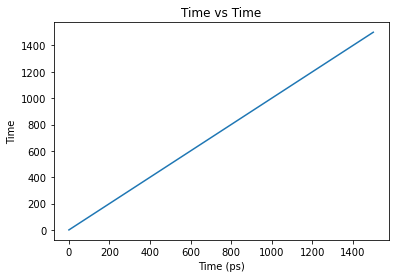

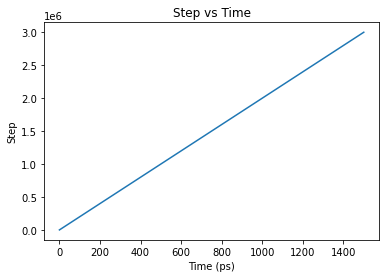

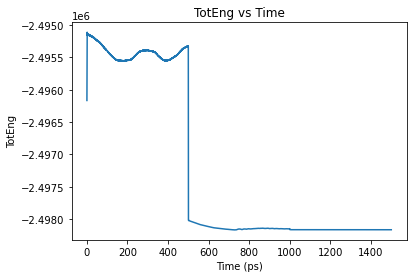

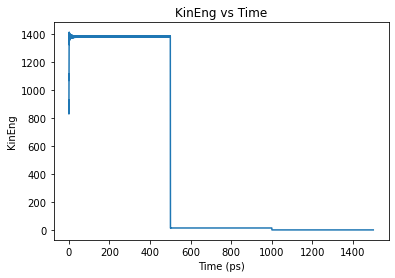

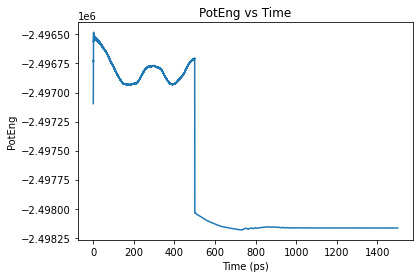

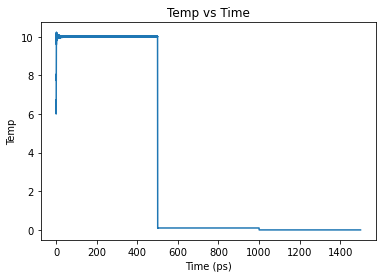

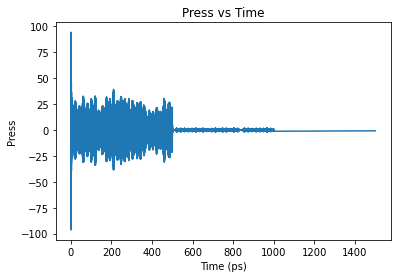

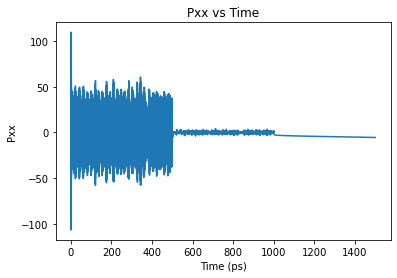

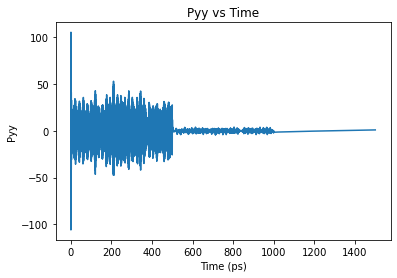

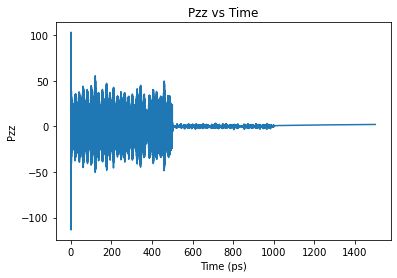

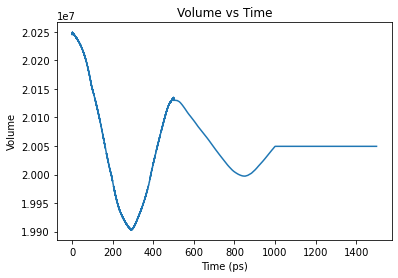

In [17]:
# Read the data into a pandas DataFrame
data = pd.DataFrame(sim_lines, columns = header)

columns = header # ["KinEng", "PotEng", "Temp", "Press", "Volume"]
for column in columns:
    fig, ax = plt.subplots()
    ax.plot(data["Step"][skip_lines:]*dt, data[column][skip_lines:])
    ax.set_xlabel("Time (ps)")
    ax.set_ylabel(column)
    ax.set_title(f"{column} vs Time")

    # Save the figure to a file
    plt.savefig(f"{column}_vs_time.tif", dpi= 100, bbox_inches = 'tight', facecolor="w")
    plt.show()
    # Close the figure to free memory
    plt.close(fig)

In [ ]:
directory_path = os.getcwd()
foldername = "Output_" + "_".join(str(x) for x in jid_list)        # Folder name

new_directory_path = os.path.join(directory_path, foldername)
if not os.path.exists(new_directory_path):
    os.makedirs(new_directory_path)

# Move all the *.tif files to the new directory
tif_files = glob.glob("*.tif")
for file in tif_files:
    shutil.move(file, os.path.join(new_directory_path, file))

shutil.move("Output.dat", os.path.join(new_directory_path, "Output.dat"))
shutil.move("Data.dat", os.path.join(new_directory_path, "Data.dat"))